In [1]:
from larcv import larcv
import numpy
import datetime

base_path = '/Users/deltutto/nextnew_files/mmkekic_dataset_larcv/'

io = larcv.IOManager()
io.add_in_file(base_path + 'next_new_classification_train.h5')
io.initialize()

True

In [2]:
event_energy_mc = {}
event_energy_mc['bkg'] = []
event_energy_mc['sig'] = []
total_events = io.get_n_entries()

for i in range(io.get_n_entries()):
    io.read_entry(i)
    
    image3d = larcv.EventSparseTensor3D.to_sparse_tensor(io.get_data("sparse3d", "voxels_E"))
    energy = image3d.as_vector().front().sum()
    
    particle = larcv.EventParticle.to_particle(io.get_data("particle", "label"))
    if particle.as_vector().front().pdg_code() == 0:
        event_energy_mc['bkg'].append(energy)
    else:
        event_energy_mc['sig'].append(energy)
        
    if i % 10000 == 0:
        print("On entry ", i, " of ", io.get_n_entries())
    
print('Number of MC events:', total_events)

('On entry ', 0, ' of ', 68855)
('On entry ', 10000, ' of ', 68855)
('On entry ', 20000, ' of ', 68855)
('On entry ', 30000, ' of ', 68855)
('On entry ', 40000, ' of ', 68855)
('On entry ', 50000, ' of ', 68855)
('On entry ', 60000, ' of ', 68855)
('Number of MC events:', 68855)


In [3]:
import pandas
import glob
import os
import argparse
import numpy
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from random import random

In [4]:
import textwrap

def measurement_string(x, u_x):
    """
    Display a value-uncertainty pair with the same precision.
    """
    scale = int(np.floor(np.log10(u_x)))
    if scale >= 2:
        return "({}) · 1e{}".format(measurement_string(  x/10**scale,
                                                       u_x/10**scale),
                                    scale)
    n = 1 - scale

    format = "{" + ":.{}f".format(n) + "}"
    string = "{} +- {}".format(format, format)

    return string.format(np.round(  x, n),
                         np.round(u_x, n))

In [5]:
from scipy.optimize import curve_fit

def gauss(x, amp, mu, sigma):
    return amp/(2*np.pi)**.5/sigma * np.exp(-0.5*(x-mu)**2./sigma**2.)

def exp(x, a0, tau):
    return a0 * np.exp(x/tau) 

def expgauss(x, a0, tau, amp, mu, sigma):
    return a0 * np.exp(x/tau) + amp/(2*np.pi)**.5/sigma * np.exp(-0.5*(x-mu)**2./sigma**2.)

def get_errors(cov):
    """
    Find errors from covariance matrix
    Parameters
    ----------
    cov : np.ndarray
        Covariance matrix of the fit parameters.
    Returns
    -------
    err : 1-dim np.ndarray
        Errors asociated to the fit parameters.
    """
    return np.sqrt(np.diag(cov))

def fit(func, x, y, seed=(), fit_range=None, **kwargs):
    if fit_range is not None:
        sel = (fit_range[0] <= x) & (x < fit_range[1])
        x, y = x[sel], y[sel]
        
    vals, cov = curve_fit(func, x, y, seed, **kwargs)
    
    fitf = lambda x: func(x, *vals)
    
    return fitf, vals, get_errors(cov)

(0.0081532633231347663, -1219.2410204343003, 0.13067539143647552, 1811.4829467923278, 7.9358460244401794)
('Total number of events:', 0.16172112975791192)


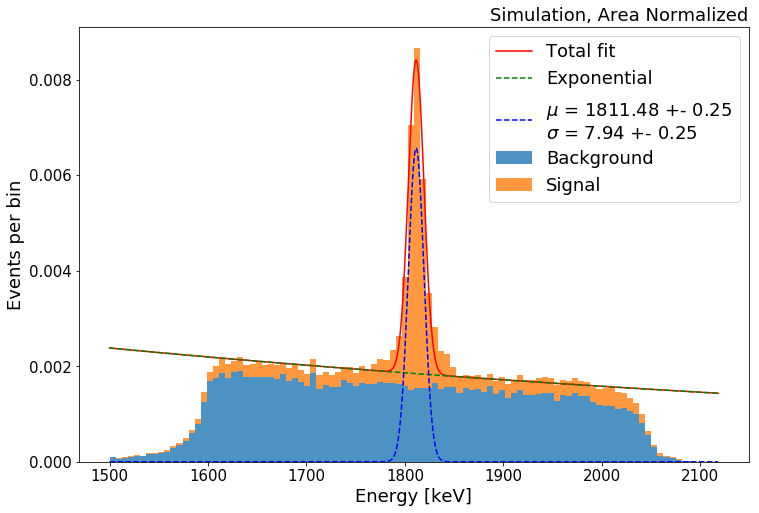

0.878837972402


In [6]:
fig = plt.figure(figsize=(12,8),facecolor='w')

peak_energy = 1592
scale_factor = 1
total_events = len(event_energy_mc['sig']) + len(event_energy_mc['bkg'])

scale = 1

n_plot = 1

energies_sig = np.array(event_energy_mc['sig'])
energies_bkg = np.array(event_energy_mc['bkg'])
# energies = energies/1e4

energies_sig = energies_sig[energies_sig > 1500]
energies_bkg = energies_bkg[energies_bkg > 1500]

n, bins, patches = plt.hist([energies_bkg, energies_sig], bins=100, normed=1, stacked=True, alpha=0.8, label=['Background', 'Signal'])
# n_bkg, bins, patches = plt.hist(energies_bkg, bins=100, normed=1, stacked=True, alpha=0.8, weights=len(energies_bkg)*[scale])

# n = n_sig + n_bkg
n = n[1]


binscenters = numpy.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
seed = 15, -445, 15000, 1800, 11
fitf, vals, errs = fit(func=expgauss, x=binscenters, y=n, seed=seed, fit_range=(1600, 2050))
    
xmin = min(bins)
xmax = max(bins)
xf = np.linspace(xmin, xmax, 1000)

legend = textwrap.dedent("""$\mu$ = {0}\n$\sigma$ = {1}""".format(measurement_string(vals[3] , errs[3]),
                    measurement_string(vals[4] , errs[4])))

print (vals[0], vals[1], vals[2], vals[3], vals[4])
plt.plot(xf, fitf(xf), 'r-', label='Total fit')
plt.plot(xf, exp(xf, vals[0], vals[1]), 'g--', label='Exponential')
plt.plot(xf, gauss(xf, vals[2], vals[3], vals[4]), 'b--', label=legend)
    
plt.title('Simulation, Area Normalized', loc='right', fontsize=18)
    
plt.legend(fontsize=18)
plt.ylabel('Events per bin',fontsize=18)
plt.xlabel('Energy [keV]',fontsize=18)
plt.tick_params(labelsize=15)
    
scale_factor = peak_energy / (vals[3])

print ('Total number of events:', np.sum(n))
plt.savefig('mc_raw_tote_fitted.pdf')
plt.show()
print scale_factor

In [ ]:
fig = plt.figure(figsize=(12,8),facecolor='w')
print scale_factor
scale = 1

n_plot = 1

energies_sig = np.array(event_energy_mc['sig'])
energies_bkg = np.array(event_energy_mc['bkg'])
energies_sig = energies_sig * scale_factor
energies_sig = energies_sig[energies_sig > 1250]
energies_bkg = energies_bkg * scale_factor
energies_bkg = energies_bkg[energies_bkg > 1250]

n, bins, patches = plt.hist([energies_bkg, energies_sig], bins=100, normed=1, stacked=True, alpha=0.8, label=['Background', 'Signal'])
# n, bins, patches = plt.hist(energies, bins=100, normed=1, alpha=0.8, weights=len(energies)*[scale])
n = n[1]

binscenters = numpy.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
seed = 15, -445, 15000, 1600, 11
fitf, vals, errs = fit(func=expgauss, x=binscenters, y=n, seed=seed, fit_range=(1400, 1800))
    
xmin = min(bins)
xmax = max(bins)
xf = np.linspace(xmin, xmax, 1000)

legend = textwrap.dedent("""$\mu$ = {0}\n$\sigma$ = {1}""".format(measurement_string(vals[3] , errs[3]),
                    measurement_string(vals[4] , errs[4])))

print (vals[0], vals[1], vals[2], vals[3], vals[4])
plt.plot(xf, fitf(xf), 'r-', label='Total fit')
plt.plot(xf, exp(xf, vals[0], vals[1]), 'g--', label='Exponential')
plt.plot(xf, gauss(xf, vals[2], vals[3], vals[4]), 'b--', label=legend)
    
plt.title('Simulation', loc='right')
    
plt.legend()
plt.ylabel('Events per bin',fontsize=18)
plt.xlabel('Energy [keV]',fontsize=18)
plt.tick_params(labelsize=15)

print ('Total number of events:', np.sum(n))
plt.savefig('mc_raw_tote_fitted_scaled.pdf')
plt.show()



In [ ]:
from scipy.integrate import quad
I_expgauss = quad(expgauss, 1400, 1800, args=(vals[0], vals[1], vals[2], vals[3], vals[4]))
I_exp = quad(exp, 1400, 1800, args=(vals[0], vals[1]))
I_gauss = quad(gauss, 1400, 1800, args=(vals[2], vals[3], vals[4]))
print ('Fitted. Total events =', I_expgauss[0] * total_events, 
                'Background events =', I_exp[0] * total_events, 
                'Signal events =', I_gauss[0] * total_events)